In [9]:
from importlib import reload
import tensorflow as tf
from utils_v2 import *

In [10]:
import StrawberryDQNAgent
reload(StrawberryDQNAgent)
from StrawberryDQNAgent import StrawberryDQNAgent

In [5]:
import datetime

In [11]:
agent = StrawberryDQNAgent(cash_supply=5000, epsilon_decay=0.9995) # super slow decay

In [ ]:
# features
agent.external_states

In [22]:
import matplotlib.pyplot as plt

def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError ("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError ("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y


def plot_test(start_time, end_time=None):

    if end_time is None: # default: one day
        end_time = agent.env.end_index
        
    df = agent.env.df
    df = df.loc[df.index >= start_time]
    df = df.loc[df.index <= end_time]
    prices = df['USDT_BTC_open']
#     print(prices.shape)
#     print(smooth(prices))
    
    actions = agent.test_actions
    actions = actions[actions.index >= start_time]
    actions = actions[actions.index < end_time]

    fig, ax1 = plt.subplots(figsize = (15, 8))

    ax1.plot(prices.index, prices, 'b-')
    ax1.set_ylabel('Price', color='b', fontsize=15)
    ax1.tick_params('y', colors='b', labelsize=15)

    hold = actions[actions == 1]
    buy = actions[actions == 2]
    sell = actions[actions == 0]


    
    sm =  smooth(prices,24)[12:len(prices.index)+12]
    import numpy as np
    from scipy.signal import argrelextrema

    local_minima = argrelextrema(sm,np.less) 
    local_maxima = argrelextrema(sm,np.greater)
    turning = np.concatenate((local_minima[0],local_maxima[0]),axis=0)
    turning = np.append(turning,0)
    turning = np.append(turning,len(prices.index) - 1)
    turning.sort()
    sell_first = True
    if (prices[0] < prices[1]):
        sell_first = False
    l_turning = list(turning)
    edge = []
    edge.append(0)
    for i in range(len(l_turning) - 1):
        edge.append((l_turning[i] + l_turning[i + 1])//2)
    edge.append(len(prices.index) - 1)
    
    good_action = []
    cur_action = 0 # sell
    last_edge = 0
    if (not sell_first):
        cur_action = 2 # buy
    for i in range(1,len(edge)):
        target_edge = edge[i]
        for j in np.arange(last_edge,target_edge,1):
            good_action.append(cur_action)
        cur_action = 2 - cur_action
        last_edge = target_edge
        
    good_action_df = pd.DataFrame()
    good_action_df["good_action"] = good_action
    good_action_df.index = actions.index


    
    good_buy = actions[(actions == 2) & (actions == good_action)]
    bad_buy = actions[(actions== 2) & (actions != good_action)]
    good_sell = actions[(actions == 0) & (actions == good_action)]
    bad_sell = actions[(actions== 0) & (actions != good_action)] 
        
    ax2 = ax1.twinx()
    ax2.scatter(hold.index, hold, c='blue', label='HOLD')
    ax2.scatter(good_buy.index, good_buy, c='green', marker = 'o',label='GOOD_BUY')
    ax2.scatter(bad_buy.index, bad_buy, c='red',marker = 'x', label='BAD_BUY')
    ax2.scatter(good_sell.index, good_sell, c='green', marker = 'o', label='GOOD_SELL')
    ax2.scatter(bad_sell.index, bad_sell, c='red', marker = 'x', label='BAD_SELL')
    ax2.set_yticks([])
    ax2.legend(loc=1, fontsize=15)
        
    
    ax3 = ax1.twinx()
    ax3.plot(prices.index,sm, 'r-')
    ax3.tick_params('y_smooth', colors='r', labelsize=15)
    ax3.set_yticks([])
    
    ax4 = ax1.twinx()
#     ax4.set_ylim(0,6000)
    ax4.plot(prices.index, agent.test_portfolio_values_cash, 'y', label='Cash Value')
    ax4.plot(prices.index, agent.test_portfolio_values_coin, 'orange', label='Coin Value in USD')
    ax4.legend(loc=4, fontsize=15)

    plt.xlim(actions.index[0], actions.index[-1])       

    plt.show()

# Set Experiment Name

In [12]:
experiment_name = 'Strawberry'

# Train (2017-01-01 ~ 2018-01-01)

In [13]:
agent.epsilon = 1
agent.epsilon_min = 0.005

In [14]:
train_start = datetime.datetime(2017,1,1,0)
train_end = datetime.datetime(2018,1,1,0)

sess = tf.Session()
agent.train(experiment_name=experiment_name, session=sess, start_time = train_start, \
            end_time = train_end, num_episodes=1000000, verbose=False, auto_save_and_load=False) # SHOULD USE MORE EPOCHS!!!

Auto loading is off. Creating model with fresh parameters.
Training, randomly selecting episodes from  2017-01-01 00:00:00  to 2018-01-01 00:00:00 :  ~ 365 days

regression loss:  35699612.0
regression loss:  35228944.0
episode: 1/1000000, returns: 0.44, epsilon: 1.0
regression loss:  41440828.0
regression loss:  35799308.0
episode: 2/1000000, returns: -8.8, epsilon: 1.0
regression loss:  88514424.0
regression loss:  23220090.0
episode: 3/1000000, returns: 1.3, epsilon: 1.0
regression loss:  19937844.0
regression loss:  18946884.0
episode: 4/1000000, returns: -8.1, epsilon: 1.0
regression loss:  137983620.0
regression loss:  121090650.0
episode: 5/1000000, returns: 2.8, epsilon: 1.0
regression loss:  113795720.0
regression loss:  320696580.0
episode: 6/1000000, returns: 3.3, epsilon: 1.0
regression loss:  169997440.0
regression loss:  190855710.0
episode: 7/1000000, returns: 5.0, epsilon: 1.0
regression loss:  33680310.0
regression loss:  79348170.0
episode: 8/1000000, returns: -7.8, e

regression loss:  299028.16
regression loss:  1348107.8
episode: 77/1000000, returns: 2.0, epsilon: 0.96
regression loss:  214976.05
regression loss:  1494462.1
episode: 78/1000000, returns: 4.1, epsilon: 0.96
regression loss:  383472.9
regression loss:  1063560.9
episode: 79/1000000, returns: 1.5, epsilon: 0.96
regression loss:  271807.97
regression loss:  1180022.2
episode: 80/1000000, returns: -2.2, epsilon: 0.96
regression loss:  148117.66
regression loss:  1181995.9
episode: 81/1000000, returns: 8.1, epsilon: 0.96
regression loss:  115506.31
regression loss:  896179.6
episode: 82/1000000, returns: 3.9, epsilon: 0.96
regression loss:  90342.01
regression loss:  961774.9
episode: 83/1000000, returns: 8.6, epsilon: 0.96
regression loss:  106387.23
regression loss:  977709.0
episode: 84/1000000, returns: 3.6, epsilon: 0.96
regression loss:  70957.33
regression loss:  915191.44
episode: 85/1000000, returns: 6.4, epsilon: 0.96
regression loss:  73671.19
regression loss:  827957.44
episo

regression loss:  3768.425
regression loss:  6878.1436
episode: 155/1000000, returns: -1.3, epsilon: 0.93
regression loss:  3082.7708
regression loss:  12488.851
episode: 156/1000000, returns: 1.2, epsilon: 0.92
regression loss:  7341.675
regression loss:  13121.358
episode: 157/1000000, returns: 5.3, epsilon: 0.92
regression loss:  3815.5354
regression loss:  12020.909
episode: 158/1000000, returns: 0.47, epsilon: 0.92
regression loss:  810.0279
regression loss:  11814.415
episode: 159/1000000, returns: -3.4, epsilon: 0.92
regression loss:  8491.355
regression loss:  12223.468
episode: 160/1000000, returns: 0.61, epsilon: 0.92
regression loss:  1354.1929
regression loss:  12334.484
episode: 161/1000000, returns: -0.78, epsilon: 0.92
regression loss:  13211.846
regression loss:  28685.205
episode: 162/1000000, returns: 2.8, epsilon: 0.92
regression loss:  12450.787
regression loss:  12550.444
episode: 163/1000000, returns: 9.8, epsilon: 0.92
regression loss:  2722.089
regression loss: 

regression loss:  1047.2958
regression loss:  4578.1416
episode: 233/1000000, returns: -5.0, epsilon: 0.89
regression loss:  3142.888
regression loss:  4888.7773
episode: 234/1000000, returns: -5.9, epsilon: 0.89
regression loss:  562.5091
regression loss:  5780.2246
episode: 235/1000000, returns: 0.12, epsilon: 0.89
regression loss:  1725.2408
regression loss:  5061.853
episode: 236/1000000, returns: 6.0, epsilon: 0.89
regression loss:  2972.8398
regression loss:  4036.477
episode: 237/1000000, returns: -0.89, epsilon: 0.89
regression loss:  2564.5178
regression loss:  3693.8123
episode: 238/1000000, returns: 0.098, epsilon: 0.89
regression loss:  5307.1655
regression loss:  12001.965
episode: 239/1000000, returns: -0.8, epsilon: 0.89
regression loss:  5597.025
regression loss:  10773.239
episode: 240/1000000, returns: 0.49, epsilon: 0.89
regression loss:  5434.0063
regression loss:  9566.207
episode: 241/1000000, returns: -0.64, epsilon: 0.89
regression loss:  2294.129
regression los

regression loss:  1162.0879
regression loss:  12566.844
episode: 311/1000000, returns: -1.5, epsilon: 0.86
regression loss:  5501.062
regression loss:  16051.07
episode: 312/1000000, returns: 7.0, epsilon: 0.86
regression loss:  2792.6062
regression loss:  11732.633
episode: 313/1000000, returns: -2.7, epsilon: 0.86
regression loss:  6027.829
regression loss:  18179.883
episode: 314/1000000, returns: -0.41, epsilon: 0.85
regression loss:  2526.6401
regression loss:  19250.3
episode: 315/1000000, returns: -3.5, epsilon: 0.85
regression loss:  5979.611
regression loss:  11822.373
episode: 316/1000000, returns: -5.4, epsilon: 0.85
regression loss:  3502.2122
regression loss:  15432.463
episode: 317/1000000, returns: 6.5, epsilon: 0.85
regression loss:  1975.4668
regression loss:  16053.343
episode: 318/1000000, returns: 1.5, epsilon: 0.85
regression loss:  1565.4067
regression loss:  12156.78
episode: 319/1000000, returns: 0.33, epsilon: 0.85
regression loss:  3287.1272
regression loss:  

regression loss:  22028.371
episode: 388/1000000, returns: 6.0, epsilon: 0.82
regression loss:  4050.3145
regression loss:  13237.632
episode: 389/1000000, returns: -6.2, epsilon: 0.82
regression loss:  17600.145
regression loss:  25681.32
episode: 390/1000000, returns: 1e+01, epsilon: 0.82
regression loss:  7793.374
regression loss:  16185.248
episode: 391/1000000, returns: 1.6, epsilon: 0.82
regression loss:  868.659
regression loss:  13915.646
episode: 392/1000000, returns: -1.7, epsilon: 0.82
regression loss:  2275.8728
regression loss:  9461.57
episode: 393/1000000, returns: -0.7, epsilon: 0.82
regression loss:  929.13696
regression loss:  11357.543
episode: 394/1000000, returns: 0.56, epsilon: 0.82
regression loss:  967.80334
regression loss:  6855.1206
episode: 395/1000000, returns: -0.087, epsilon: 0.82
regression loss:  1713.0393
regression loss:  8174.6978
episode: 396/1000000, returns: -4.1, epsilon: 0.82
regression loss:  819.45435
regression loss:  5652.1304
episode: 397/1

regression loss:  1221.749
regression loss:  11828.99
episode: 466/1000000, returns: 1.9, epsilon: 0.79
regression loss:  14241.05
regression loss:  20071.734
episode: 467/1000000, returns: 4.1, epsilon: 0.79
regression loss:  11399.478
regression loss:  6373.743
episode: 468/1000000, returns: 1.2e+01, epsilon: 0.79
regression loss:  2878.1301
regression loss:  15476.04
episode: 469/1000000, returns: 2.6, epsilon: 0.79
regression loss:  5258.4683
regression loss:  19255.535
episode: 470/1000000, returns: 3.3, epsilon: 0.79
regression loss:  1363.1313
regression loss:  16843.516
episode: 471/1000000, returns: -6.4, epsilon: 0.79
regression loss:  8438.393
regression loss:  10389.615
episode: 472/1000000, returns: -2.5, epsilon: 0.79
regression loss:  7663.722
regression loss:  12239.053
episode: 473/1000000, returns: 1.7, epsilon: 0.79
regression loss:  1625.4565
regression loss:  14781.643
episode: 474/1000000, returns: -1.7, epsilon: 0.79
regression loss:  1717.5476
regression loss:  

episode: 543/1000000, returns: 6.3, epsilon: 0.76
regression loss:  9107.427
regression loss:  7790.7773
episode: 544/1000000, returns: -2.1, epsilon: 0.76
regression loss:  378.35745
regression loss:  8597.726
episode: 545/1000000, returns: 0.48, epsilon: 0.76
regression loss:  15843.712
regression loss:  10013.0625
episode: 546/1000000, returns: 3.2, epsilon: 0.76
regression loss:  2480.8342
regression loss:  5406.6157
episode: 547/1000000, returns: -4.1, epsilon: 0.76
regression loss:  1808.9104
regression loss:  6352.8496
episode: 548/1000000, returns: -2.2, epsilon: 0.76
regression loss:  919.0243
regression loss:  4977.8286
episode: 549/1000000, returns: 1.6, epsilon: 0.76
regression loss:  499.50372
regression loss:  3989.7087
episode: 550/1000000, returns: 1.1e+01, epsilon: 0.76
regression loss:  370.92456
regression loss:  4481.795
episode: 551/1000000, returns: 4.8, epsilon: 0.76
regression loss:  233.35341
regression loss:  2578.4153
episode: 552/1000000, returns: 1.2e+01, e

regression loss:  5078.916
regression loss:  11273.604
episode: 621/1000000, returns: 8.4, epsilon: 0.73
regression loss:  1738.7366
regression loss:  4701.5703
episode: 622/1000000, returns: -1.2e+01, epsilon: 0.73
regression loss:  6481.0522
regression loss:  5971.8364
episode: 623/1000000, returns: 1.1, epsilon: 0.73
regression loss:  1078.3536
regression loss:  12426.836
episode: 624/1000000, returns: -2.5, epsilon: 0.73
regression loss:  17561.832
regression loss:  20696.86
episode: 625/1000000, returns: -6.7, epsilon: 0.73
regression loss:  3808.9375
regression loss:  25858.316
episode: 626/1000000, returns: -2.5, epsilon: 0.73
regression loss:  10706.352
regression loss:  27131.496
episode: 627/1000000, returns: 2.1, epsilon: 0.73
regression loss:  13677.812
regression loss:  13139.523
episode: 628/1000000, returns: -3.3, epsilon: 0.73
regression loss:  646.5756
regression loss:  8867.967
episode: 629/1000000, returns: -8.6, epsilon: 0.73
regression loss:  5653.8394
regression l

regression loss:  12003.35
episode: 698/1000000, returns: -0.26, epsilon: 0.71
regression loss:  8457.349
regression loss:  11221.044
episode: 699/1000000, returns: -0.21, epsilon: 0.7
regression loss:  3366.8984
regression loss:  10745.399
episode: 700/1000000, returns: -1.1, epsilon: 0.7
regression loss:  7061.1113
regression loss:  5730.63
episode: 701/1000000, returns: 0.36, epsilon: 0.7
regression loss:  1526.1957
regression loss:  6522.205
episode: 702/1000000, returns: -7.2, epsilon: 0.7
regression loss:  3593.0378
regression loss:  4900.957
episode: 703/1000000, returns: -0.42, epsilon: 0.7
regression loss:  2529.448
regression loss:  6930.7666
episode: 704/1000000, returns: -0.77, epsilon: 0.7
regression loss:  5096.6997
regression loss:  4791.5273
episode: 705/1000000, returns: 7.7, epsilon: 0.7
regression loss:  13481.658
regression loss:  10581.102
episode: 706/1000000, returns: -4.8, epsilon: 0.7
regression loss:  13125.833
regression loss:  6839.9155
episode: 707/1000000,

regression loss:  3671.778
regression loss:  5571.463
episode: 776/1000000, returns: 8.8, epsilon: 0.68
regression loss:  788.5695
regression loss:  3622.5493
episode: 777/1000000, returns: -4.7, epsilon: 0.68
regression loss:  1649.2354
regression loss:  7090.5664
episode: 778/1000000, returns: 7.3, epsilon: 0.68
regression loss:  4896.627
regression loss:  7319.445
episode: 779/1000000, returns: -1.6, epsilon: 0.68
regression loss:  556.16016
regression loss:  5680.7812
episode: 780/1000000, returns: -0.19, epsilon: 0.68
regression loss:  4639.6177
regression loss:  8561.984
episode: 781/1000000, returns: 0.45, epsilon: 0.68
regression loss:  1122.835
regression loss:  6450.8906
episode: 782/1000000, returns: -6.8, epsilon: 0.68
regression loss:  2033.0215
regression loss:  5441.833
episode: 783/1000000, returns: -0.67, epsilon: 0.68
regression loss:  5054.5693
regression loss:  11706.646
episode: 784/1000000, returns: 0.17, epsilon: 0.68
regression loss:  2734.5159
regression loss: 

episode: 853/1000000, returns: 1.5, epsilon: 0.65
regression loss:  7275.099
regression loss:  45406.74
episode: 854/1000000, returns: 3.9, epsilon: 0.65
regression loss:  15702.849
regression loss:  28265.27
episode: 855/1000000, returns: 6.0, epsilon: 0.65
regression loss:  12521.646
regression loss:  30667.93
episode: 856/1000000, returns: -6.0, epsilon: 0.65
regression loss:  10529.732
regression loss:  27524.777
episode: 857/1000000, returns: 0.25, epsilon: 0.65
regression loss:  20493.096
regression loss:  52083.758
episode: 858/1000000, returns: -3.7, epsilon: 0.65
regression loss:  24987.629
regression loss:  51392.52
episode: 859/1000000, returns: 4.3, epsilon: 0.65
regression loss:  4804.8564
regression loss:  46896.984
episode: 860/1000000, returns: -4.9, epsilon: 0.65
regression loss:  13788.173
regression loss:  32688.627
episode: 861/1000000, returns: 0.6, epsilon: 0.65
regression loss:  20661.502
regression loss:  33545.395
episode: 862/1000000, returns: 3.9, epsilon: 0.

regression loss:  9844.006
regression loss:  22524.68
episode: 931/1000000, returns: 0.5, epsilon: 0.63
regression loss:  9896.055
regression loss:  15250.621
episode: 932/1000000, returns: -2.1, epsilon: 0.63
regression loss:  18246.043
regression loss:  20941.293
episode: 933/1000000, returns: 7.7, epsilon: 0.63
regression loss:  10152.227
regression loss:  16790.137
episode: 934/1000000, returns: -5.0, epsilon: 0.63
regression loss:  3823.124
regression loss:  12647.0625
episode: 935/1000000, returns: 3.9, epsilon: 0.63
regression loss:  6817.6724
regression loss:  13179.5625
episode: 936/1000000, returns: 2.3, epsilon: 0.63
regression loss:  1207.7362
regression loss:  23715.602
episode: 937/1000000, returns: 2.4, epsilon: 0.63
regression loss:  5118.275
regression loss:  7912.925
episode: 938/1000000, returns: -1.2, epsilon: 0.63
regression loss:  2140.4673
regression loss:  10443.975
episode: 939/1000000, returns: -0.69, epsilon: 0.63
regression loss:  5041.468
regression loss:  

regression loss:  38186.676
episode: 1008/1000000, returns: -0.12, epsilon: 0.6
regression loss:  44688.664
regression loss:  69690.04
episode: 1009/1000000, returns: 2.6, epsilon: 0.6
regression loss:  14661.343
regression loss:  31516.25
episode: 1010/1000000, returns: 2.3, epsilon: 0.6
regression loss:  2407.6475
regression loss:  35040.82
episode: 1011/1000000, returns: 0.99, epsilon: 0.6
regression loss:  9150.687
regression loss:  18164.492
episode: 1012/1000000, returns: 0.92, epsilon: 0.6
regression loss:  2825.307
regression loss:  19892.6
episode: 1013/1000000, returns: 4.5, epsilon: 0.6
regression loss:  2001.0382
regression loss:  13053.518
episode: 1014/1000000, returns: -3.9, epsilon: 0.6
regression loss:  1897.5681
regression loss:  12345.024
episode: 1015/1000000, returns: -0.32, epsilon: 0.6
regression loss:  1742.8396
regression loss:  10462.198
episode: 1016/1000000, returns: -3.5, epsilon: 0.6
regression loss:  3413.9087
regression loss:  15046.189
episode: 1017/100

regression loss:  9509.232
episode: 1085/1000000, returns: -0.62, epsilon: 0.58
regression loss:  2345.4426
regression loss:  10789.191
episode: 1086/1000000, returns: -1.1, epsilon: 0.58
regression loss:  4382.991
regression loss:  4479.633
episode: 1087/1000000, returns: 2.3, epsilon: 0.58
regression loss:  4176.91
regression loss:  7814.1875
episode: 1088/1000000, returns: -7.5, epsilon: 0.58
regression loss:  3419.6821
regression loss:  9274.872
episode: 1089/1000000, returns: 1.7, epsilon: 0.58
regression loss:  4005.7612
regression loss:  10329.504
episode: 1090/1000000, returns: 1.4, epsilon: 0.58
regression loss:  3499.9902
regression loss:  3417.5413
episode: 1091/1000000, returns: 1.7, epsilon: 0.58
regression loss:  922.0783
regression loss:  10676.152
episode: 1092/1000000, returns: 5.0, epsilon: 0.58
regression loss:  1774.0925
regression loss:  5464.84
episode: 1093/1000000, returns: 3.0, epsilon: 0.58
regression loss:  5377.71
regression loss:  4632.202
episode: 1094/100

regression loss:  5412.397
regression loss:  8199.563
episode: 1162/1000000, returns: 9.3, epsilon: 0.56
regression loss:  20207.113
regression loss:  20816.441
episode: 1163/1000000, returns: 2.7, epsilon: 0.56
regression loss:  7382.9736
regression loss:  9101.075
episode: 1164/1000000, returns: -0.77, epsilon: 0.56
regression loss:  14149.453
regression loss:  17775.137
episode: 1165/1000000, returns: 3.9, epsilon: 0.56
regression loss:  14811.942
regression loss:  15407.896
episode: 1166/1000000, returns: -0.6, epsilon: 0.56
regression loss:  6473.0894
regression loss:  8760.838
episode: 1167/1000000, returns: 3.3, epsilon: 0.56
regression loss:  2214.1362
regression loss:  22135.227
episode: 1168/1000000, returns: 0.91, epsilon: 0.56
regression loss:  8837.234
regression loss:  25111.75
episode: 1169/1000000, returns: 7.3, epsilon: 0.56
regression loss:  1346.7556
regression loss:  14443.391
episode: 1170/1000000, returns: 0.4, epsilon: 0.56
regression loss:  15080.203
regression 

episode: 1238/1000000, returns: 8.0, epsilon: 0.54
regression loss:  1589.6797
regression loss:  1670.1667
episode: 1239/1000000, returns: 4.7, epsilon: 0.54
regression loss:  2979.9468
regression loss:  2257.3843
episode: 1240/1000000, returns: -1.2e+01, epsilon: 0.54
regression loss:  1031.3135
regression loss:  5028.84
episode: 1241/1000000, returns: -4.5, epsilon: 0.54
regression loss:  4748.008
regression loss:  5642.5273
episode: 1242/1000000, returns: 1.8, epsilon: 0.54
regression loss:  649.8128
regression loss:  2974.0981
episode: 1243/1000000, returns: 0.16, epsilon: 0.54
regression loss:  1423.0817
regression loss:  5026.982
episode: 1244/1000000, returns: 5.0, epsilon: 0.54
regression loss:  172.3166
regression loss:  2445.3765
episode: 1245/1000000, returns: -3.2, epsilon: 0.54
regression loss:  590.6795
regression loss:  1232.6896
episode: 1246/1000000, returns: 0.89, epsilon: 0.54
regression loss:  326.67242
regression loss:  2892.0537
episode: 1247/1000000, returns: 0.1

regression loss:  4852.2256
episode: 1315/1000000, returns: 5.5, epsilon: 0.52
regression loss:  5086.5996
regression loss:  9177.443
episode: 1316/1000000, returns: 0.98, epsilon: 0.52
regression loss:  486.6043
regression loss:  2857.9653
episode: 1317/1000000, returns: 3.2, epsilon: 0.52
regression loss:  298.7509
regression loss:  3998.4536
episode: 1318/1000000, returns: 0.22, epsilon: 0.52
regression loss:  1650.2708
regression loss:  2192.899
episode: 1319/1000000, returns: 1.5, epsilon: 0.52
regression loss:  203.42862
regression loss:  2329.477
episode: 1320/1000000, returns: 0.86, epsilon: 0.52
regression loss:  1065.8778
regression loss:  2528.579
episode: 1321/1000000, returns: 1e+01, epsilon: 0.52
regression loss:  3463.4995
regression loss:  3937.7307
episode: 1322/1000000, returns: 5.1, epsilon: 0.52
regression loss:  1816.9476
regression loss:  2699.7356
episode: 1323/1000000, returns: 1.4, epsilon: 0.52
regression loss:  390.5864
regression loss:  1327.0017
episode: 13

regression loss:  7635.4785
episode: 1392/1000000, returns: -3.6, epsilon: 0.5
regression loss:  4234.0293
regression loss:  12651.375
episode: 1393/1000000, returns: 1e+01, epsilon: 0.5
regression loss:  7261.2437
regression loss:  3598.0605
episode: 1394/1000000, returns: 6.8, epsilon: 0.5
regression loss:  3852.6868
regression loss:  5566.3315
episode: 1395/1000000, returns: -2.1, epsilon: 0.5
regression loss:  1179.7927
regression loss:  5801.6484
episode: 1396/1000000, returns: 3.4, epsilon: 0.5
regression loss:  1476.2411
regression loss:  5297.863
episode: 1397/1000000, returns: 1.2e+01, epsilon: 0.5
regression loss:  1112.9867
regression loss:  2853.507
episode: 1398/1000000, returns: 8.2, epsilon: 0.5
regression loss:  1103.6526
regression loss:  5126.255
episode: 1399/1000000, returns: 5.1, epsilon: 0.5
regression loss:  237.05281
regression loss:  3050.828
episode: 1400/1000000, returns: 1.2, epsilon: 0.5
regression loss:  354.87592
regression loss:  2168.8857
episode: 1401/

regression loss:  1344.8414
regression loss:  4445.9663
episode: 1469/1000000, returns: 2.8, epsilon: 0.48
regression loss:  577.5993
regression loss:  2103.722
episode: 1470/1000000, returns: -4.2, epsilon: 0.48
regression loss:  5961.641
regression loss:  3674.0366
episode: 1471/1000000, returns: -4.7, epsilon: 0.48
regression loss:  1676.4987
regression loss:  5954.9463
episode: 1472/1000000, returns: 0.54, epsilon: 0.48
regression loss:  6449.969
regression loss:  3938.3535
episode: 1473/1000000, returns: -0.95, epsilon: 0.48
regression loss:  883.56714
regression loss:  5273.751
episode: 1474/1000000, returns: -5.8, epsilon: 0.48
regression loss:  9916.641
regression loss:  7975.1562
episode: 1475/1000000, returns: 5.9, epsilon: 0.48
regression loss:  23733.117
regression loss:  5140.1084
episode: 1476/1000000, returns: 1.1, epsilon: 0.48
regression loss:  1486.7299
regression loss:  8458.23
episode: 1477/1000000, returns: -5.6, epsilon: 0.48
regression loss:  466.4214
regression 

regression loss:  4616.09
regression loss:  6786.94
episode: 1546/1000000, returns: 1.5, epsilon: 0.46
regression loss:  8650.552
regression loss:  11598.158
episode: 1547/1000000, returns: 0.78, epsilon: 0.46
regression loss:  917.71484
regression loss:  2464.7954
episode: 1548/1000000, returns: 0.82, epsilon: 0.46
regression loss:  2867.3875
regression loss:  4440.4873
episode: 1549/1000000, returns: -8.7, epsilon: 0.46
regression loss:  462.64334
regression loss:  3868.0654
episode: 1550/1000000, returns: 1.2, epsilon: 0.46
regression loss:  583.1906
regression loss:  3213.2954
episode: 1551/1000000, returns: 1.2, epsilon: 0.46
regression loss:  944.6398
regression loss:  4095.7424
episode: 1552/1000000, returns: 0.056, epsilon: 0.46
regression loss:  1302.8641
regression loss:  2686.893
episode: 1553/1000000, returns: 0.95, epsilon: 0.46
regression loss:  529.078
regression loss:  2713.6768
episode: 1554/1000000, returns: 2.0, epsilon: 0.46
regression loss:  398.13718
regression lo

regression loss:  8415.656
regression loss:  4004.57
episode: 1623/1000000, returns: 0.14, epsilon: 0.44
regression loss:  3779.4468
regression loss:  17500.152
episode: 1624/1000000, returns: 3.1, epsilon: 0.44
regression loss:  8832.038
regression loss:  4845.49
episode: 1625/1000000, returns: -2.5, epsilon: 0.44
regression loss:  2596.9316
regression loss:  5038.1934
episode: 1626/1000000, returns: 4.9, epsilon: 0.44
regression loss:  54959.945
regression loss:  42073.95
episode: 1627/1000000, returns: -2.4, epsilon: 0.44
regression loss:  53352.13
regression loss:  22789.457
episode: 1628/1000000, returns: -0.89, epsilon: 0.44
regression loss:  2638.1152
regression loss:  14805.7
episode: 1629/1000000, returns: -5.2, epsilon: 0.44
regression loss:  21089.43
regression loss:  57358.996
episode: 1630/1000000, returns: 0.5, epsilon: 0.44
regression loss:  35429.51
regression loss:  16807.24
episode: 1631/1000000, returns: -6.7, epsilon: 0.44
regression loss:  4100.092
regression loss:

episode: 1699/1000000, returns: -2.1, epsilon: 0.43
regression loss:  142.69046
regression loss:  1225.2114
episode: 1700/1000000, returns: 0.77, epsilon: 0.43
regression loss:  125.21485
regression loss:  2601.7488
episode: 1701/1000000, returns: 0.22, epsilon: 0.43
regression loss:  827.84045
regression loss:  1846.0779
episode: 1702/1000000, returns: -6.6, epsilon: 0.43
regression loss:  3595.1736
regression loss:  3381.344
episode: 1703/1000000, returns: 2.2, epsilon: 0.43
regression loss:  618.0843
regression loss:  1528.2379
episode: 1704/1000000, returns: -1.6, epsilon: 0.43
regression loss:  2014.6337
regression loss:  2385.7798
episode: 1705/1000000, returns: 0.36, epsilon: 0.43
regression loss:  1606.6843
regression loss:  4865.2266
episode: 1706/1000000, returns: 4.2, epsilon: 0.43
regression loss:  4406.416
regression loss:  7918.33
episode: 1707/1000000, returns: 4.1, epsilon: 0.43
regression loss:  2317.0532
regression loss:  5467.7666
episode: 1708/1000000, returns: -0.6

regression loss:  350.27048
regression loss:  1675.3545
episode: 1776/1000000, returns: 0.53, epsilon: 0.41
regression loss:  845.8643
regression loss:  1075.5663
episode: 1777/1000000, returns: 2.4, epsilon: 0.41
regression loss:  388.20993
regression loss:  950.4425
episode: 1778/1000000, returns: -2.3, epsilon: 0.41
regression loss:  1768.1144
regression loss:  2295.131
episode: 1779/1000000, returns: -6.2, epsilon: 0.41
regression loss:  293.15405
regression loss:  285.47433
episode: 1780/1000000, returns: -0.12, epsilon: 0.41
regression loss:  1603.8651
regression loss:  1182.1569
episode: 1781/1000000, returns: -2.3, epsilon: 0.41
regression loss:  230.67435
regression loss:  113.47891
episode: 1782/1000000, returns: -3.1, epsilon: 0.41
regression loss:  26.365229
regression loss:  78.07523
episode: 1783/1000000, returns: 3.3, epsilon: 0.41
regression loss:  1240.9246
regression loss:  1051.8575
episode: 1784/1000000, returns: -0.9, epsilon: 0.41
regression loss:  376.6068
regres

regression loss:  3382.8826
regression loss:  5970.5034
episode: 1853/1000000, returns: 1.1, epsilon: 0.4
regression loss:  1001.5874
regression loss:  878.4429
episode: 1854/1000000, returns: -0.46, epsilon: 0.4
regression loss:  340.65527
regression loss:  354.5249
episode: 1855/1000000, returns: 0.23, epsilon: 0.4
regression loss:  479.69498
regression loss:  416.4078
episode: 1856/1000000, returns: 3.0, epsilon: 0.4
regression loss:  496.6412
regression loss:  220.22151
episode: 1857/1000000, returns: -1.0, epsilon: 0.4
regression loss:  908.0735
regression loss:  743.6242
episode: 1858/1000000, returns: -1.3, epsilon: 0.39
regression loss:  356.61908
regression loss:  559.574
episode: 1859/1000000, returns: -0.59, epsilon: 0.39
regression loss:  381.87195
regression loss:  104.62207
episode: 1860/1000000, returns: 3.9, epsilon: 0.39
regression loss:  47.403366
regression loss:  912.8201
episode: 1861/1000000, returns: 0.13, epsilon: 0.39
regression loss:  1498.0837
regression loss

episode: 1929/1000000, returns: -0.65, epsilon: 0.38
regression loss:  1496.0763
regression loss:  1116.2454
episode: 1930/1000000, returns: 0.8, epsilon: 0.38
regression loss:  804.84656
regression loss:  1080.6125
episode: 1931/1000000, returns: 1.4, epsilon: 0.38
regression loss:  1718.0566
regression loss:  804.4892
episode: 1932/1000000, returns: -7.7, epsilon: 0.38
regression loss:  933.1603
regression loss:  3988.664
episode: 1933/1000000, returns: 4.4, epsilon: 0.38
regression loss:  915.81055
regression loss:  3259.8806
episode: 1934/1000000, returns: -1.9, epsilon: 0.38
regression loss:  508.99393
regression loss:  1174.3528
episode: 1935/1000000, returns: 0.41, epsilon: 0.38
regression loss:  399.38632
regression loss:  2094.5085
episode: 1936/1000000, returns: -1.7, epsilon: 0.38
regression loss:  990.69727
regression loss:  876.16394
episode: 1937/1000000, returns: 0.85, epsilon: 0.38
regression loss:  2247.7412
regression loss:  3412.6824
episode: 1938/1000000, returns: -

regression loss:  8732.692
episode: 2006/1000000, returns: 1.1, epsilon: 0.37
regression loss:  27869.895
regression loss:  12666.977
episode: 2007/1000000, returns: 0.94, epsilon: 0.37
regression loss:  669.83734
regression loss:  12095.321
episode: 2008/1000000, returns: 1.4, epsilon: 0.37
regression loss:  4593.0796
regression loss:  11909.129
episode: 2009/1000000, returns: 1.4, epsilon: 0.37
regression loss:  3010.3115
regression loss:  7050.4883
episode: 2010/1000000, returns: -4.2, epsilon: 0.37
regression loss:  3305.4783
regression loss:  10047.352
episode: 2011/1000000, returns: -0.8, epsilon: 0.37
regression loss:  1223.9387
regression loss:  5849.869
episode: 2012/1000000, returns: 2.0, epsilon: 0.37
regression loss:  4541.013
regression loss:  13189.084
episode: 2013/1000000, returns: 0.6, epsilon: 0.37
regression loss:  1965.3007
regression loss:  5400.4355
episode: 2014/1000000, returns: 4.3, epsilon: 0.37
regression loss:  8086.679
regression loss:  13565.699
episode: 2

regression loss:  4201.8506
regression loss:  12589.827
episode: 2083/1000000, returns: 2.0, epsilon: 0.35
regression loss:  10667.921
regression loss:  10168.009
episode: 2084/1000000, returns: 0.29, epsilon: 0.35
regression loss:  1277.4874
regression loss:  8767.227
episode: 2085/1000000, returns: -1.1, epsilon: 0.35
regression loss:  13661.056
regression loss:  20600.338
episode: 2086/1000000, returns: 7.6, epsilon: 0.35
regression loss:  19600.623
regression loss:  22868.016
episode: 2087/1000000, returns: 0.37, epsilon: 0.35
regression loss:  3409.3262
regression loss:  5783.622
episode: 2088/1000000, returns: 4.0, epsilon: 0.35
regression loss:  8504.782
regression loss:  25570.207
episode: 2089/1000000, returns: -4.0, epsilon: 0.35
regression loss:  94337.23
regression loss:  20792.086
episode: 2090/1000000, returns: -0.56, epsilon: 0.35
regression loss:  6178.973
regression loss:  6135.5986
episode: 2091/1000000, returns: -3.8, epsilon: 0.35
regression loss:  3082.8298
regress

regression loss:  2129.7622
regression loss:  4268.8745
episode: 2160/1000000, returns: 1.3, epsilon: 0.34
regression loss:  2228.5742
regression loss:  10433.674
episode: 2161/1000000, returns: 0.92, epsilon: 0.34
regression loss:  545.4079
regression loss:  4087.096
episode: 2162/1000000, returns: -0.6, epsilon: 0.34
regression loss:  1143.5782
regression loss:  4318.506
episode: 2163/1000000, returns: 0.7, epsilon: 0.34
regression loss:  279.77643
regression loss:  2242.7236
episode: 2164/1000000, returns: -0.62, epsilon: 0.34
regression loss:  672.9029
regression loss:  2254.1003
episode: 2165/1000000, returns: 1.9, epsilon: 0.34
regression loss:  1822.6581
regression loss:  1736.1187
episode: 2166/1000000, returns: -3.7, epsilon: 0.34
regression loss:  2211.9395
regression loss:  2511.0867
episode: 2167/1000000, returns: -4.6, epsilon: 0.34
regression loss:  2286.1487
regression loss:  5803.051
episode: 2168/1000000, returns: 1.6, epsilon: 0.34
regression loss:  1291.5665
regressi

regression loss:  900.45306
regression loss:  1123.3339
episode: 2237/1000000, returns: -5.6, epsilon: 0.33
regression loss:  1825.0592
regression loss:  2827.4822
episode: 2238/1000000, returns: 0.036, epsilon: 0.33
regression loss:  1207.6346
regression loss:  2933.1414
episode: 2239/1000000, returns: 5.0, epsilon: 0.33
regression loss:  12289.1875
regression loss:  6672.075
episode: 2240/1000000, returns: 3.1, epsilon: 0.33
regression loss:  5445.7617
regression loss:  6572.7627
episode: 2241/1000000, returns: -1.3, epsilon: 0.33
regression loss:  691.2355
regression loss:  543.8123
episode: 2242/1000000, returns: -9.7, epsilon: 0.33
regression loss:  1367.2213
regression loss:  1108.5256
episode: 2243/1000000, returns: -1.4, epsilon: 0.33
regression loss:  2885.205
regression loss:  1655.5046
episode: 2244/1000000, returns: 2.0, epsilon: 0.33
regression loss:  192.22214
regression loss:  118.53584
episode: 2245/1000000, returns: 0.49, epsilon: 0.33
regression loss:  130.19437
regre

regression loss:  909.92566
regression loss:  1570.0437
episode: 2314/1000000, returns: 3.5, epsilon: 0.31
regression loss:  677.2933
regression loss:  1507.6116
episode: 2315/1000000, returns: -0.19, epsilon: 0.31
regression loss:  701.15875
regression loss:  1812.9933
episode: 2316/1000000, returns: 2.6, epsilon: 0.31
regression loss:  2689.164
regression loss:  4633.9585
episode: 2317/1000000, returns: -0.12, epsilon: 0.31
regression loss:  280.56848
regression loss:  3633.8877
episode: 2318/1000000, returns: -2.7, epsilon: 0.31
regression loss:  5965.149
regression loss:  4409.5234
episode: 2319/1000000, returns: 6.9, epsilon: 0.31
regression loss:  279.5891
regression loss:  4556.1064
episode: 2320/1000000, returns: 0.069, epsilon: 0.31
regression loss:  717.3779
regression loss:  1087.0958
episode: 2321/1000000, returns: -0.084, epsilon: 0.31
regression loss:  536.41675
regression loss:  4322.485
episode: 2322/1000000, returns: 9.7, epsilon: 0.31
regression loss:  223.91066
regre

episode: 2390/1000000, returns: -0.16, epsilon: 0.3
regression loss:  1678.7751
regression loss:  4216.2017
episode: 2391/1000000, returns: 3.5, epsilon: 0.3
regression loss:  330.98132
regression loss:  3701.9712
episode: 2392/1000000, returns: -2.5, epsilon: 0.3
regression loss:  288.67117
regression loss:  2741.044
episode: 2393/1000000, returns: -4.3, epsilon: 0.3
regression loss:  409.6195
regression loss:  2045.6774
episode: 2394/1000000, returns: -6.4, epsilon: 0.3
regression loss:  137.60379
regression loss:  1748.3079
episode: 2395/1000000, returns: -3.3, epsilon: 0.3
regression loss:  442.97562
regression loss:  1199.3964
episode: 2396/1000000, returns: 0.63, epsilon: 0.3
regression loss:  188.22717
regression loss:  998.4763
episode: 2397/1000000, returns: -0.0083, epsilon: 0.3
regression loss:  175.32928
regression loss:  1425.5417
episode: 2398/1000000, returns: 0.71, epsilon: 0.3
regression loss:  1369.0986
regression loss:  2032.8031
episode: 2399/1000000, returns: 3.0, 

regression loss:  4349.736
episode: 2467/1000000, returns: 3.4, epsilon: 0.29
regression loss:  200.85695
regression loss:  1329.2698
episode: 2468/1000000, returns: -0.0095, epsilon: 0.29
regression loss:  1467.9684
regression loss:  4979.157
episode: 2469/1000000, returns: 1.5, epsilon: 0.29
regression loss:  3396.956
regression loss:  3222.9492
episode: 2470/1000000, returns: -1.0, epsilon: 0.29
regression loss:  1434.2152
regression loss:  4926.868
episode: 2471/1000000, returns: 0.42, epsilon: 0.29
regression loss:  782.7874
regression loss:  1371.0533
episode: 2472/1000000, returns: 3.2, epsilon: 0.29
regression loss:  270.43192
regression loss:  4740.7886
episode: 2473/1000000, returns: -1.5, epsilon: 0.29
regression loss:  1615.9747
regression loss:  2367.6338
episode: 2474/1000000, returns: -0.19, epsilon: 0.29
regression loss:  1788.6962
regression loss:  6573.151
episode: 2475/1000000, returns: -5.3, epsilon: 0.29
regression loss:  1022.4291
regression loss:  2001.7996
episo

regression loss:  651.5874
regression loss:  3238.9353
episode: 2544/1000000, returns: -0.62, epsilon: 0.28
regression loss:  1964.5763
regression loss:  1002.83765
episode: 2545/1000000, returns: -7.8, epsilon: 0.28
regression loss:  2578.1216
regression loss:  3223.4314
episode: 2546/1000000, returns: -3.2, epsilon: 0.28
regression loss:  1593.124
regression loss:  2826.149
episode: 2547/1000000, returns: 1.5e+01, epsilon: 0.28
regression loss:  727.43243
regression loss:  2252.2983
episode: 2548/1000000, returns: -5.7, epsilon: 0.28
regression loss:  422.74792
regression loss:  2210.893
episode: 2549/1000000, returns: 2.1, epsilon: 0.28
regression loss:  1734.6676
regression loss:  1460.3387
episode: 2550/1000000, returns: -6.4, epsilon: 0.28
regression loss:  378.39185
regression loss:  1868.6952
episode: 2551/1000000, returns: 1.6, epsilon: 0.28
regression loss:  508.2365
regression loss:  1900.0623
episode: 2552/1000000, returns: 1.5, epsilon: 0.28
regression loss:  1494.36
regre

episode: 2620/1000000, returns: 0.52, epsilon: 0.27
regression loss:  347.13626
regression loss:  3421.1775
episode: 2621/1000000, returns: -0.58, epsilon: 0.27
regression loss:  261.42612
regression loss:  1730.2107
episode: 2622/1000000, returns: 8.7, epsilon: 0.27
regression loss:  6317.313
regression loss:  4703.8047
episode: 2623/1000000, returns: -0.74, epsilon: 0.27
regression loss:  3912.8206
regression loss:  4760.0405
episode: 2624/1000000, returns: -0.62, epsilon: 0.27
regression loss:  262.05005
regression loss:  1718.213
episode: 2625/1000000, returns: 5.7, epsilon: 0.27
regression loss:  2456.543
regression loss:  2873.3418
episode: 2626/1000000, returns: 1e+01, epsilon: 0.27
regression loss:  3056.7756
regression loss:  3512.9614
episode: 2627/1000000, returns: 5.1, epsilon: 0.27
regression loss:  8300.518
regression loss:  953.149
episode: 2628/1000000, returns: 4.1, epsilon: 0.27
regression loss:  1960.3958
regression loss:  2870.9048
episode: 2629/1000000, returns: 1.

regression loss:  312.1771
regression loss:  1573.7389
episode: 2697/1000000, returns: -2.1, epsilon: 0.26
regression loss:  1315.6274
regression loss:  2214.2046
episode: 2698/1000000, returns: 1.2, epsilon: 0.26
regression loss:  256.16757
regression loss:  2368.1367
episode: 2699/1000000, returns: -2.4, epsilon: 0.26
regression loss:  27621.152
regression loss:  9292.66
episode: 2700/1000000, returns: 0.1, epsilon: 0.26
regression loss:  1864.1187
regression loss:  3358.755
episode: 2701/1000000, returns: -0.23, epsilon: 0.26
regression loss:  11242.187
regression loss:  7403.254
episode: 2702/1000000, returns: -2.8, epsilon: 0.26
regression loss:  4305.868
regression loss:  5552.9946
episode: 2703/1000000, returns: 1.1, epsilon: 0.26
regression loss:  3125.929
regression loss:  4146.6426
episode: 2704/1000000, returns: -0.81, epsilon: 0.26
regression loss:  1481.4644
regression loss:  5041.076
episode: 2705/1000000, returns: -0.79, epsilon: 0.26
regression loss:  375.10318
regressi

regression loss:  425.09283
regression loss:  2637.392
episode: 2774/1000000, returns: -0.3, epsilon: 0.25
regression loss:  996.9375
regression loss:  4741.049
episode: 2775/1000000, returns: -0.5, epsilon: 0.25
regression loss:  117.6569
regression loss:  1647.5
episode: 2776/1000000, returns: 0.52, epsilon: 0.25
regression loss:  1529.6711
regression loss:  4385.741
episode: 2777/1000000, returns: 0.97, epsilon: 0.25
regression loss:  9112.601
regression loss:  6840.002
episode: 2778/1000000, returns: -0.88, epsilon: 0.25
regression loss:  3987.4375
regression loss:  1999.7708
episode: 2779/1000000, returns: -0.26, epsilon: 0.25
regression loss:  3160.6506
regression loss:  4629.4595
episode: 2780/1000000, returns: 1.6, epsilon: 0.25
regression loss:  3794.9622
regression loss:  1831.4587
episode: 2781/1000000, returns: 5.0, epsilon: 0.25
regression loss:  10673.237
regression loss:  5991.656
episode: 2782/1000000, returns: 4.9, epsilon: 0.25
regression loss:  1312.5835
regression l

episode: 2850/1000000, returns: -7.9, epsilon: 0.24
regression loss:  552.8904
regression loss:  4510.443
episode: 2851/1000000, returns: 5.2, epsilon: 0.24
regression loss:  987.6566
regression loss:  1180.2107
episode: 2852/1000000, returns: 0.52, epsilon: 0.24
regression loss:  2139.6333
regression loss:  4151.3823
episode: 2853/1000000, returns: 0.27, epsilon: 0.24
regression loss:  906.4733
regression loss:  2869.396
episode: 2854/1000000, returns: 0.42, epsilon: 0.24
regression loss:  2266.337
regression loss:  3016.607
episode: 2855/1000000, returns: 0.42, epsilon: 0.24
regression loss:  1067.9541
regression loss:  2638.8594
episode: 2856/1000000, returns: 0.21, epsilon: 0.24
regression loss:  356.15387
regression loss:  10615.738
episode: 2857/1000000, returns: 2.3, epsilon: 0.24
regression loss:  1581.2542
regression loss:  508.41904
episode: 2858/1000000, returns: 2.4, epsilon: 0.24
regression loss:  700.039
regression loss:  1878.1741
episode: 2859/1000000, returns: 0.53, ep

regression loss:  674.93506
regression loss:  2266.8901
episode: 2927/1000000, returns: -2.4, epsilon: 0.23
regression loss:  884.5117
regression loss:  1784.3137
episode: 2928/1000000, returns: 0.092, epsilon: 0.23
regression loss:  958.01886
regression loss:  1889.3649
episode: 2929/1000000, returns: 4.4, epsilon: 0.23
regression loss:  1122.5975
regression loss:  2673.7703
episode: 2930/1000000, returns: 0.25, epsilon: 0.23
regression loss:  1021.3313
regression loss:  2899.9282
episode: 2931/1000000, returns: -9.9, epsilon: 0.23
regression loss:  2072.2705
regression loss:  2892.9402
episode: 2932/1000000, returns: 2.7, epsilon: 0.23
regression loss:  21.711111
regression loss:  116.93664
episode: 2933/1000000, returns: -2.7, epsilon: 0.23
regression loss:  59.4807
regression loss:  21.686024
episode: 2934/1000000, returns: -3.8, epsilon: 0.23
regression loss:  62.722816
regression loss:  195.49188
episode: 2935/1000000, returns: -0.79, epsilon: 0.23
regression loss:  119.831825
re

KeyboardInterrupt: 

# Sanity check

In [15]:
agent.env.set_current_time(datetime.datetime(2017,12,1,0))

In [16]:
agent.env.step()
state = agent.env.getStatesSequence() + agent.portfolio.getStates()
agent.preprocess(state, agent.env.getCurrentPrice())
# state -= agent.state_mean
print(state[:10])

agent.model.predict(sess, state)

[0.9532575377826319, 0.9267650050798705, 0.9401831129058176, 0.9304050337685525, 0.9406253897460588, 0.007633262057391906, 0.009181824126555549, 0.0, 2.0, 2.0]


array([[22.258205  , -0.13544695, 22.522032  ]], dtype=float32)

# Save Model (Optional)

In [17]:
agent.saver.save(sess, "./"+experiment_name+"/model.ckpt")

'./Strawberry/model.ckpt'

# Test on (2017-09-01 ~ 2018,1,1,0) Cheating...

In [32]:
test_start = datetime.datetime(2017,9,1,0)
test_end = datetime.datetime(2018,1,1,0)
agent.test(sess, start_time = test_start, end_time = test_end, verbose=True)

Testing from  2017-09-01 00:00:00  to 2018-01-01 00:00:00 :  ~ 122 days

Current time: 2017-09-01 00:00:00
Action start: Action.BUY , Total value before action: 5000.0
Before buying: coin:0.000, cash:5000.000, buy price:4738.100
After buying: coin bought:0.106, transaction fees:1.250, coin now:0.106, cash now:4498.750
Action end:  Action.BUY , Total value now: 4998.750.  , Return since entry: -0.025 %

Current time: 2017-09-02 00:00:00
Action start: Action.BUY , Total value before action: 5043.521220695726
Before buying: coin:0.309, cash:3526.057, buy price:4906.800
After buying: coin bought:0.072, transaction fees:0.882, coin now:0.381, cash now:3172.570
Action end:  Action.BUY , Total value now: 5042.640.  , Return since entry: 0.853 %

Current time: 2017-09-03 00:00:00
Action start: Action.BUY , Total value before action: 4924.619428819393
Before buying: coin:0.323, cash:3442.661, buy price:4591.637
After buying: coin bought:0.075, transaction fees:0.861, coin now:0.398, cash now:30

Current time: 2017-09-26 00:00:00
Action start: Action.SELL , Total value before action: 4425.279011224328
Before selling: coin:0.386, cash:2907.019, sell price:3935.100
After selling: coin sold:0.039, transaction fees:0.380, coin now:0.347, cash now:3058.465
Action end:  Action.SELL , Total value now: 4424.899.  , Return since entry: -11.502 %

Current time: 2017-09-27 00:00:00
Action start: Action.SELL , Total value before action: 4407.270658149797
Before selling: coin:0.414, cash:2788.231, sell price:3914.700
After selling: coin sold:0.041, transaction fees:0.405, coin now:0.372, cash now:2949.730
Action end:  Action.SELL , Total value now: 4406.866.  , Return since entry: -11.863 %

Current time: 2017-09-28 00:00:00
Action start: Action.BUY , Total value before action: 4487.532265966885
Before buying: coin:0.317, cash:3166.356, buy price:4174.160
After buying: coin bought:0.076, transaction fees:0.792, coin now:0.392, cash now:2848.929
Action end:  Action.BUY , Total value now: 448

Current time: 2017-10-20 00:00:00
Action start: Action.BUY , Total value before action: 4665.211115667727
Before buying: coin:0.244, cash:3269.480, buy price:5711.447
After buying: coin bought:0.057, transaction fees:0.817, coin now:0.302, cash now:2941.714
Action end:  Action.BUY , Total value now: 4664.394.  , Return since entry: -6.712 %

Current time: 2017-10-21 00:00:00
Action start: Action.SELL , Total value before action: 4711.528024592947
Before selling: coin:0.255, cash:3192.508, sell price:5955.000
After selling: coin sold:0.026, transaction fees:0.380, coin now:0.230, cash now:3344.030
Action end:  Action.SELL , Total value now: 4711.148.  , Return since entry: -5.777 %

Current time: 2017-10-22 00:00:00
Action start: Action.SELL , Total value before action: 4719.457995252014
Before selling: coin:0.258, cash:3156.448, sell price:6047.379
After selling: coin sold:0.026, transaction fees:0.391, coin now:0.233, cash now:3312.358
Action end:  Action.SELL , Total value now: 4719.

Current time: 2017-11-13 00:00:00
Action start: Action.SELL , Total value before action: 4400.384940863468
Before selling: coin:0.235, cash:2993.000, sell price:5986.736
After selling: coin sold:0.024, transaction fees:0.352, coin now:0.212, cash now:3133.387
Action end:  Action.SELL , Total value now: 4400.033.  , Return since entry: -11.999 %

Current time: 2017-11-14 00:00:00
Action start: Action.SELL , Total value before action: 4560.390019825452
Before selling: coin:0.257, cash:2858.661, sell price:6616.350
After selling: coin sold:0.026, transaction fees:0.425, coin now:0.231, cash now:3028.408
Action end:  Action.SELL , Total value now: 4559.965.  , Return since entry: -8.801 %

Current time: 2017-11-15 00:00:00
Action start: Action.SELL , Total value before action: 4580.704825878818
Before selling: coin:0.256, cash:2857.102, sell price:6720.466
After selling: coin sold:0.026, transaction fees:0.431, coin now:0.231, cash now:3029.031
Action end:  Action.SELL , Total value now: 4

Current time: 2017-12-08 00:00:00
Action start: Action.SELL , Total value before action: 5952.357743186307
Before selling: coin:0.121, cash:3912.351, sell price:16849.930
After selling: coin sold:0.012, transaction fees:0.510, coin now:0.109, cash now:4115.842
Action end:  Action.SELL , Total value now: 5951.848.  , Return since entry: 19.037 %

Current time: 2017-12-09 00:00:00
Action start: Action.SELL , Total value before action: 5832.615500080685
Before selling: coin:0.138, cash:3664.965, sell price:15700.000
After selling: coin sold:0.014, transaction fees:0.542, coin now:0.124, cash now:3881.188
Action end:  Action.SELL , Total value now: 5832.074.  , Return since entry: 16.641 %

Current time: 2017-12-10 00:00:00
Action start: Action.SELL , Total value before action: 5621.773941895847
Before selling: coin:0.144, cash:3584.109, sell price:14148.454
After selling: coin sold:0.014, transaction fees:0.509, coin now:0.130, cash now:3787.367
Action end:  Action.SELL , Total value now:

Current time: 2018-01-01 00:00:00
Action start: Action.BUY , Total value before action: 5389.355607077374
Before buying: coin:0.113, cash:3831.408, buy price:13800.000
After buying: coin bought:0.028, transaction fees:0.958, coin now:0.141, cash now:3447.309
Action end:  Action.BUY , Total value now: 5388.398.  , Return since entry: 7.768 %

Percentage return: 7.767955100869913


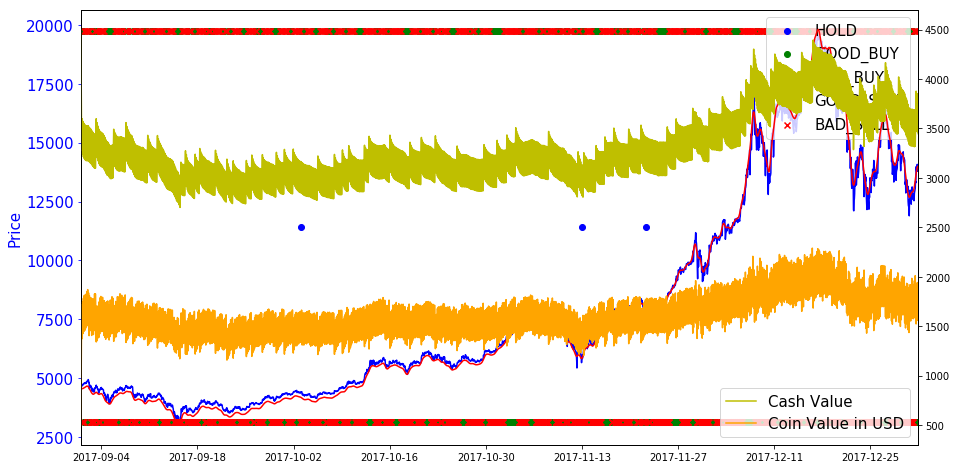

In [33]:
plot_test(test_start, test_end)

# Test on unseen time period (2018-01-01 ~ 2018-04-01 )

In [30]:
test_start = datetime.datetime(2018,1,1,0)
test_end = datetime.datetime(2018,4,1,0)
agent.test(sess, start_time = test_start, end_time = test_end, verbose=True)

Testing from  2018-01-01 00:00:00  to 2018-04-01 00:00:00 :  ~ 90 days

Current time: 2018-01-01 00:00:00
Action start: Action.BUY , Total value before action: 5000.0
Before buying: coin:0.000, cash:5000.000, buy price:13564.000
After buying: coin bought:0.037, transaction fees:1.250, coin now:0.037, cash now:4498.750
Action end:  Action.BUY , Total value now: 4998.750.  , Return since entry: -0.025 %

Current time: 2018-01-02 00:00:00
Action start: Action.BUY , Total value before action: 5019.407747525067
Before buying: coin:0.110, cash:3496.175, buy price:13811.000
After buying: coin bought:0.025, transaction fees:0.874, coin now:0.136, cash now:3145.684
Action end:  Action.BUY , Total value now: 5018.534.  , Return since entry: 0.371 %

Current time: 2018-01-03 00:00:00
Action start: Action.SELL , Total value before action: 5113.589968431124
Before selling: coin:0.110, cash:3489.334, sell price:14764.477
After selling: coin sold:0.011, transaction fees:0.406, coin now:0.099, cash no

Current time: 2018-01-25 00:00:00
Action start: Action.SELL , Total value before action: 4443.1093596059445
Before selling: coin:0.127, cash:3009.988, sell price:11297.645
After selling: coin sold:0.013, transaction fees:0.358, coin now:0.114, cash now:3152.942
Action end:  Action.SELL , Total value now: 4442.751.  , Return since entry: -11.145 %

Current time: 2018-01-26 00:00:00
Action start: Action.SELL , Total value before action: 4447.673202496388
Before selling: coin:0.131, cash:2955.455, sell price:11399.100
After selling: coin sold:0.013, transaction fees:0.373, coin now:0.118, cash now:3104.304
Action end:  Action.SELL , Total value now: 4447.300.  , Return since entry: -11.054 %

Current time: 2018-01-27 00:00:00
Action start: Action.SELL , Total value before action: 4402.30632191488
Before selling: coin:0.145, cash:2795.964, sell price:11092.090
After selling: coin sold:0.014, transaction fees:0.402, coin now:0.130, cash now:2956.197
Action end:  Action.SELL , Total value no

Current time: 2018-02-18 00:00:00
Action start: Action.BUY , Total value before action: 4146.475813470727
Before buying: coin:0.111, cash:2919.457, buy price:11065.000
After buying: coin bought:0.026, transaction fees:0.730, coin now:0.137, cash now:2626.781
Action end:  Action.BUY , Total value now: 4145.746.  , Return since entry: -17.085 %

Current time: 2018-02-19 00:00:00
Action start: Action.SELL , Total value before action: 4078.181966558863
Before selling: coin:0.121, cash:2813.375, sell price:10438.706
After selling: coin sold:0.012, transaction fees:0.316, coin now:0.109, cash now:2939.539
Action end:  Action.SELL , Total value now: 4077.866.  , Return since entry: -18.443 %

Current time: 2018-02-20 00:00:00
Action start: Action.SELL , Total value before action: 4182.487700670737
Before selling: coin:0.133, cash:2666.184, sell price:11425.000
After selling: coin sold:0.013, transaction fees:0.379, coin now:0.119, cash now:2817.435
Action end:  Action.SELL , Total value now: 

Current time: 2018-03-14 00:00:00
Action start: Action.BUY , Total value before action: 3743.4789017126104
Before buying: coin:0.120, cash:2626.872, buy price:9307.537
After buying: coin bought:0.028, transaction fees:0.657, coin now:0.148, cash now:2363.528
Action end:  Action.BUY , Total value now: 3742.822.  , Return since entry: -25.144 %

Current time: 2018-03-15 00:00:00
Action start: Action.BUY , Total value before action: 3568.7876349954113
Before buying: coin:0.127, cash:2540.643, buy price:8079.956
After buying: coin bought:0.031, transaction fees:0.635, coin now:0.159, cash now:2285.944
Action end:  Action.BUY , Total value now: 3568.152.  , Return since entry: -28.637 %

Current time: 2018-03-16 00:00:00
Action start: Action.SELL , Total value before action: 3553.414976997174
Before selling: coin:0.142, cash:2412.114, sell price:8051.883
After selling: coin sold:0.014, transaction fees:0.285, coin now:0.128, cash now:2525.959
Action end:  Action.SELL , Total value now: 3553

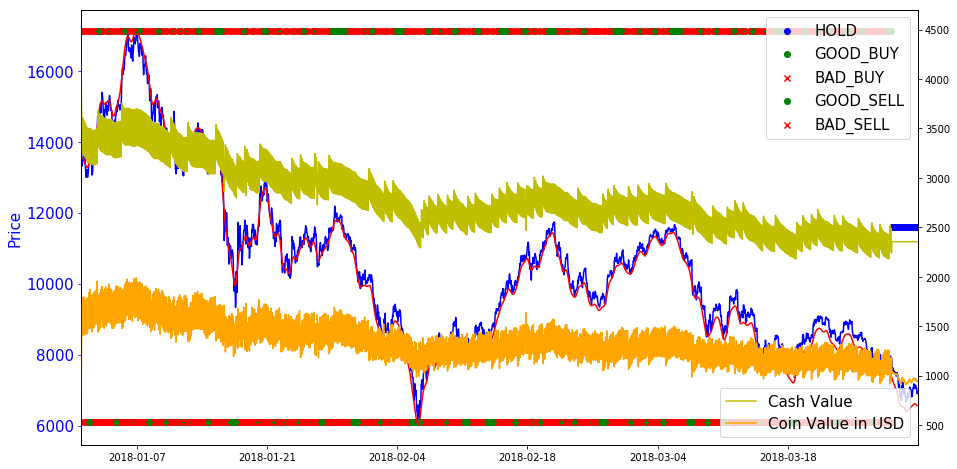

In [31]:
plot_test(test_start, test_end)

# Always buy agent

In [ ]:
from simple_agents import *

In [ ]:
always_buy_agent = AlwaysBuyAgent(Action)

In [ ]:
env = Environment()
now = datetime.datetime(2017,12,1,0)
test_end = datetime.datetime(2018,1,1,0)
env.set_current_time(now)
portfolio = Portfolio(cash_supply=1e8)
while True:
    action = always_buy_agent.get_action()
    if (env.current_index - env.start_index) / env.time_delta % 24 == 0:
        verbose = True
        print('Current time:', env.current_index)
    else:
        verbose = False
    current_price = env.getCurrentPrice()
    action = portfolio.apply_action(current_price, action, verbose=verbose)
    is_done, state = env.step()
    if env.current_index == test_end:
        break
print("Initial cash supply:", portfolio.starting_cash)
print("Final holdings:", portfolio.getCurrentHoldings(env.getCurrentPrice()))